In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from Model.model import LassoModel

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
PATH = './Model/model.pt'

In [7]:
load_model = torch.load(PATH)
model = LassoModel(119)
model.load_state_dict(load_model)

<All keys matched successfully>

In [8]:
model.eval()

LassoModel(
  (normalize): LayerNorm((119,), eps=1e-05, elementwise_affine=True)
  (hidden1): Linear(in_features=119, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [48]:
import numpy as np
from colorspace_converter import rgb_to_hsv, rgb_to_lab
from calculate_statistics import *
import itertools

input_color = np.array([[96, 108, 56], [40, 54, 24], [254, 250, 224], [221, 161, 94]])
RGB = np.empty((4,3), dtype=float)
HSV = np.empty((4,3), dtype=float)
LAB = np.empty((4,3), dtype=float)

for idx, color in enumerate(input_color):
    r, g, b = color
    RGB[idx] = np.array(color).reshape((1, 3))
    HSV[idx] = np.array([rgb_to_hsv(r, g, b)]).reshape((1, 3))
    LAB[idx] = np.array([rgb_to_lab(r, g, b)]).reshape((1, 3))

sorting_indices = np.argsort(LAB[:, 0])
RGB = RGB[sorting_indices]
HSV = HSV[sorting_indices]
LAB = LAB[sorting_indices] 

RGB_R, RGB_G, RGB_B = RGB[:, 0], RGB[:, 1], RGB[:, 2]
HSV_H, HSV_S, HSV_V = HSV[:, 0], HSV[:, 1], HSV[:, 2]
LAB_L, LAB_A, LAB_B = LAB[:, 0], LAB[:, 1], LAB[:, 2]

hue_probabilities = []
for color in HSV_H:
    probabilities = hue_probability(color, HSV)
    hue_probabilities.append(probabilities)

adjacent_probabilities = []
for i in range(len(RGB)):
    for j in range(i + 1, len(RGB)):
        color_b = HSV_H[i]
        color_c = HSV_H[j]
        adjacent_probabilities.append(hue_adjacent_probability(color_b, color_c, threshold=30))

all_CH_values = []
LCH_array = np.column_stack([LAB_L, LAB_A, HSV_H])
for color1, color2 in itertools.combinations(LCH_array, 2):
    L1, C1, H1 = color1
    L2, C2, H2 = color2
    CH_value = calculate_CH(L1, C1, H1, L2, C2, H2)
    all_CH_values.append(CH_value)

RGB_feature = [calculate_statistics(RGB_R), calculate_statistics(RGB_G), calculate_statistics(RGB_B)]
HSV_feature = [calculate_statistics(HSV_H), calculate_statistics(HSV_S), calculate_statistics(HSV_V)]
LAB_feature = [calculate_statistics(LAB_L), calculate_statistics(LAB_A), calculate_statistics(LAB_B)]
Hue_probability = [calculate_hsv_statistics(hue_probabilities)]
Hue_Log_probability = [calculate_hsv_statistics(hue_probabilities, True)]
Hue_adjacent_probability = [calculate_hsv_statistics(adjacent_probabilities)]
Hue_Log_adjacent_probability = [calculate_hsv_statistics(adjacent_probabilities, True)]
Hue_entropy = [[calculate_hue_entropy(HSV)]]
CH = [all_CH_values]
Light_gradient = [calculate_gradient(LAB_L).tolist()]
Hue_gradient = [calculate_gradient(HSV_H).tolist()]
RGB = RGB.tolist()
HSV = HSV.tolist()
CIELAB = LAB.tolist()
input_data = sum((RGB, HSV, CIELAB, RGB_feature, HSV_feature, LAB_feature, Hue_probability, Hue_Log_probability, Hue_adjacent_probability, Hue_Log_adjacent_probability, Hue_entropy, CH, Light_gradient, Hue_gradient), [])
input_data = [[element for sublist in input_data for element in sublist]]
input_data = torch.flatten(torch.tensor(input_data, dtype=torch.float32))

input_data

tensor([ 4.0000e+01,  5.4000e+01,  2.4000e+01,  9.6000e+01,  1.0800e+02,
         5.6000e+01,  2.2100e+02,  1.6100e+02,  9.4000e+01,  2.5400e+02,
         2.5000e+02,  2.2400e+02,  8.8000e+01,  5.5556e+01,  2.1176e+01,
         7.3846e+01,  4.8148e+01,  4.2353e+01,  3.1654e+01,  5.7466e+01,
         8.6667e+01,  5.2000e+01,  1.1811e+01,  9.9608e+01,  2.0656e+01,
        -1.2149e+01,  1.6924e+01,  4.3503e+01, -1.3557e+01,  2.7463e+01,
         7.0645e+01,  1.5030e+01,  4.3230e+01,  9.7963e+01, -2.9540e+00,
         1.2952e+01,  1.5275e+02,  8.7811e+01,  1.5850e+02,  2.5400e+02,
         4.0000e+01,  2.1400e+02,  1.4325e+02,  7.2317e+01,  1.3450e+02,
         2.5000e+02,  5.4000e+01,  1.9600e+02,  9.9500e+01,  7.6031e+01,
         7.5000e+01,  2.2400e+02,  2.4000e+01,  2.0000e+02,  6.1375e+01,
         2.1422e+01,  6.2923e+01,  8.8000e+01,  3.1654e+01,  5.6346e+01,
         4.3245e+01,  1.8479e+01,  5.1852e+01,  5.7466e+01,  1.1811e+01,
         4.5655e+01,  6.2451e+01,  3.1916e+01,  6.4

In [51]:
import matplotlib.pyplot as plt
import colorsys

[[ 40  54  24]
 [ 96 108  56]
 [221 161  94]
 [254 250 224]]


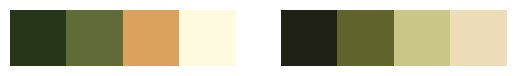

In [55]:

def hsv_to_rgb(hsv_array):
    rgb_array = np.zeros_like(hsv_array)
    for i in range(hsv_array.shape[0]):
        h, s, v = hsv_array[i] / np.array([360, 100, 100])
        r, g, b = colorsys.hsv_to_rgb(h.item(), s.item(), v.item())
        rgb_array[i] = np.array([int(r*255), int(g*255), int(b*255)])

    return rgb_array

with torch.no_grad():
    output = model(input_data)

    x = input_data[:12].type(torch.int).numpy().reshape(4,3)
    print(x)
    plt.subplot(1, 2, 1)
    plt.imshow([x])
    plt.axis(False)
    
    plt.subplot(1, 2, 2)
    y = output.type(torch.int).numpy().reshape((4,3))
    y = hsv_to_rgb(y).reshape((4,3))
    plt.imshow([y.reshape((4,3))])
    plt.axis(False)